# Fit the final model and make predictions

In [1]:
library(magrittr)

## Prepare datasets

## Take all features which aren't part of an arbitrary blacklist?

In [2]:
blacklist = readr::read_tsv('features/blacklist.tsv')$feature
feature_df = readr::read_tsv('features/transformed-features.tsv.bz2') %>%
  dplyr::select(-dplyr::one_of(blacklist))

Parsed with column specification:
cols(
  feature = col_character()
)
Parsed with column specification:
cols(
  compound_id = col_character(),
  compound_name = col_character(),
  disease_id = col_character(),
  disease_name = col_character(),
  category = col_character(),
  status = col_integer(),
  prior_prob = col_double(),
  prior_logit = col_double(),
  degree_CbG = col_double(),
  degree_CtD = col_double(),
  degree_DaG = col_double(),
  degree_DtC = col_double(),
  dwpc_CbGaD = col_double(),
  dwpc_CbGaDaGaD = col_double(),
  dwpc_CbGaDtCtD = col_double(),
  dwpc_CbGbCbGaD = col_double(),
  dwpc_CbGbCtD = col_double(),
  dwpc_CtDtCtD = col_double()
)
Warning message in dplyr::one_of(blacklist):
“Unknown variables: `dwpc_CtDtCrCtD`, `dwpc_CtDrDtCtD`, `dwpc_CcSEcCrCtD`, `dwpc_CrCtDlAlD`, `dwpc_CrCtDaGaD`, `dwpc_CrCdGdCtD`, `dwpc_CrCtDpSpD`, `dwpc_CrCuGuCtD`, `dwpc_CrCtDuGaD`, `dwpc_CrCtDdGaD`, `dwpc_CrCcSEcCtD`, `dwpc_CrCrCtDrD`, `dwpc_CdGdCrCtD`, `dwpc_CpDpCrCtD`, `dwpc_CrCtDrDrD

In [3]:
head(feature_df, 2)

compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prior_logit,degree_CbG,degree_DaG,dwpc_CbGaD,dwpc_CbGaDaGaD,dwpc_CbGbCbGaD,dwpc_CbGbCtD,dwpc_CtDtCtD
DB01048,Abacavir,DOID:10652,Alzheimer's disease,NA,0,0.004455,-5.409,-0.5939,1.076,-0.3796,1.187,-0.05063,-0.5227,-0.1685
DB05812,Abiraterone,DOID:10652,Alzheimer's disease,NA,0,0.004455,-5.409,0.4237,1.076,1.0780,1.360,1.54400,0.8474,-0.1685


In [4]:
train_df = feature_df %>%
  dplyr::filter(prior_prob > 0)

X_train = train_df %>%
  dplyr::select(prior_logit, dplyr::starts_with('degree_'), dplyr::starts_with('dwpc_')) %>%
  as.matrix()
dim(X_train)

y_train = train_df$status

[1] 24674     8

In [5]:
head(train_df)

compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prior_logit,degree_CbG,degree_DaG,dwpc_CbGaD,dwpc_CbGaDaGaD,dwpc_CbGbCbGaD,dwpc_CbGbCtD,dwpc_CtDtCtD
DB01048,Abacavir,DOID:10652,Alzheimer's disease,NA,0,0.004455,-5.409,-0.59390,1.076,-0.3796,1.1870,-0.05063,-0.52270,-0.1685
DB05812,Abiraterone,DOID:10652,Alzheimer's disease,NA,0,0.004455,-5.409,0.42370,1.076,1.0780,1.3600,1.54400,0.84740,-0.1685
DB00659,Acamprosate,DOID:10652,Alzheimer's disease,NA,0,0.004455,-5.409,0.85210,1.076,2.4360,2.6020,1.76800,4.11400,-0.1685
DB00284,Acarbose,DOID:10652,Alzheimer's disease,NA,0,0.004455,-5.409,0.28310,1.076,-0.3796,-0.5106,-0.81130,-0.52270,-0.1685
DB01193,Acebutolol,DOID:10652,Alzheimer's disease,NA,0,0.004455,-5.409,-0.06919,1.076,1.2700,1.0690,1.28200,0.56600,-0.1685
DB00819,Acetazolamide,DOID:10652,Alzheimer's disease,NA,0,0.009194,-4.680,1.01500,1.076,2.3650,1.5040,2.42500,-0.01443,-0.1685


In [6]:
sum(train_df$status)

[1] 615

## Fit Model

In [7]:
lambda = 'lambda.1se'
penalty = ifelse(colnames(X_train) == 'prior_logit', 0, 1)

In [8]:
fit = hetior::glmnet_train(X = X_train, y = y_train, alpha = 0.2, s = lambda, cores = 10, seed = 0,
  penalty.factor=penalty, lambda.min.ratio=1e-8, nlambda=150, standardize=TRUE)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



[1] 0.009542306

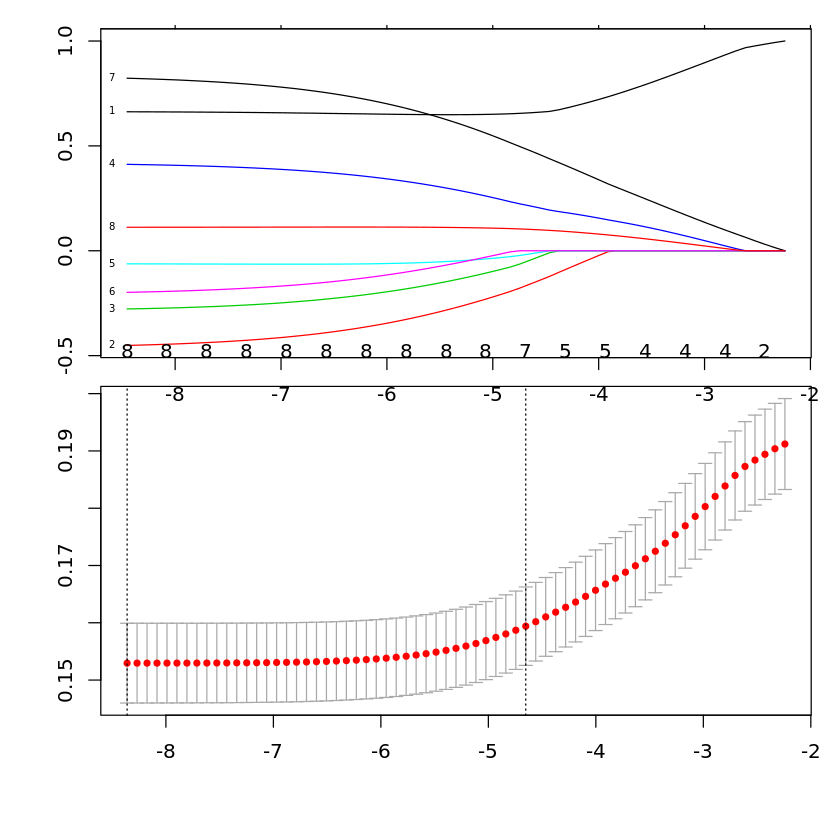

In [9]:
par(mfrow = c(2,1), oma = c(5,4,0,0) + 0.1, mar = c(0,0,1,1) + 0.1)
plot(fit$cv_model$glmnet.fit, xvar = "lambda", label = TRUE)
plot(fit$cv_model)
fit$cv_model[[lambda]]

In [10]:
# The coefficient for prior_logit should be around 1 for our approach to work well
dplyr::filter(fit$coef_df, feature == 'prior_logit')$coef

[1] 0.6576959

In [11]:
# Number of negative and positive coefficients
fit$coef_df %>%
  dplyr::filter(feature != 'intercept', zcoef != 0) %>%
  .[['zcoef']] %>% sign %>% table

.
-1  1 
 3  4 

In [12]:
# Sum of prior (should sum to the number of treatments)
sum(feature_df$prior_prob)

# Prevalence of positives as percent
scales::percent(mean(feature_df$status))

[1] 615.0067

[1] "0.329%"

In [13]:
X_all = feature_df %>%
  dplyr::mutate(prior_logit = boot::logit(mean(status))) %>%
  dplyr::select(dplyr::one_of(colnames(X_train))) %>%
  as.matrix()

y_predicted = hetior::glmnet_predict(fit$cv_model, X = X_all, s = lambda)
y_predicted %>% mean() %>% scales::percent()

[1] "0.31%"

In [14]:
train_pred_df = train_df %>%
  dplyr::select(compound_id, disease_id) %>%
  dplyr::bind_cols(dplyr::data_frame(training_prediction = fit$y_pred))

predict_df = feature_df %>%
  dplyr::select(compound_id:prior_prob, dplyr::starts_with('status')) %>%
  dplyr::mutate(prediction = y_predicted) %>%
  dplyr::left_join(train_pred_df) %>%
  dplyr::group_by(compound_id) %>%
  dplyr::mutate(compound_percentile = dplyr::cume_dist(prediction)) %>%
  dplyr::ungroup() %>%
  dplyr::group_by(disease_id) %>%
  dplyr::mutate(disease_percentile = dplyr::cume_dist(prediction)) %>%
  dplyr::ungroup() %>%
  dplyr::left_join(readr::read_tsv('../validate/validation-statuses.tsv'))

Joining, by = c("compound_id", "disease_id")
Parsed with column specification:
cols(
  compound_id = col_character(),
  compound_name = col_character(),
  disease_id = col_character(),
  disease_name = col_character(),
  n_trials = col_integer(),
  status_trials = col_integer(),
  status_drugcentral = col_integer()
)
Joining, by = c("compound_id", "compound_name", "disease_id", "disease_name")


In [15]:
predict_df %>%
  dplyr::arrange(desc(prediction)) %>%
  head(2)

compound_id,compound_name,disease_id,disease_name,category,status,prior_prob,prediction,training_prediction,compound_percentile,disease_percentile,n_trials,status_trials,status_drugcentral
DB00630,Alendronate,DOID:11476,osteoporosis,DM,1,0.03166,0.1585357,0.4596783,1,1.0000000,NA,NA,NA
DB00884,Risedronate,DOID:11476,osteoporosis,DM,1,0.03166,0.1385349,0.4206790,1,0.9992821,NA,NA,NA


## Calculate performance

In [16]:
get_metrics = function(params) {
  y_true_var = params$y_true_var
  y_pred_var = params$y_pred_var
  vtm_df = predict_df[, c(y_true_var, y_pred_var)] %>% na.omit()
  y_true = vtm_df[[1]]
  vtm = hetior::calc_vtms(y_true = y_true, y_pred = vtm_df[[2]], is_prob = T)
  dplyr::data_frame(
      y_true_var = y_true_var, y_pred_var = y_pred_var,
      n_pos = sum(y_true == 1), n_neg = sum(y_true == 0),
      auroc = vtm$auroc, auprc = vtm$auprc, tjur = vtm$tjur
  ) %>% return()
}

perf_df = tidyr::crossing(
  y_pred_var = c('prediction', 'compound_percentile', 'disease_percentile', 'training_prediction', 'prior_prob'),
  y_true_var = c('status', 'status_drugcentral', 'status_trials')
) %>%
  dplyr::rowwise() %>%
  dplyr::do(get_metrics(.))

perf_df

y_true_var,y_pred_var,n_pos,n_neg,auroc,auprc,tjur
status,compound_percentile,615,186047,0.9125759,0.033792941,0.412813212
status_drugcentral,compound_percentile,198,185079,0.8210061,0.007700997,0.321443619
status_trials,compound_percentile,5474,179803,0.6312144,0.055786362,0.131181409
status,disease_percentile,615,186047,0.9005177,0.036191529,0.404736341
status_drugcentral,disease_percentile,198,185079,0.8080846,0.005790800,0.310570612
status_trials,disease_percentile,5474,179803,0.6110012,0.050927756,0.111826886
status,prediction,615,186047,0.9502601,0.178277960,0.021927498
status_drugcentral,prediction,198,185079,0.8653077,0.028145192,0.013098055
status_trials,prediction,5474,179803,0.6681484,0.093584080,0.003402008
status,prior_prob,615,186047,0.9794506,0.142409097,0.094237444


## Write results to TSVs

In [17]:
perf_df %>% readr::write_tsv('predictions/performance.tsv')
fit$coef_df %>% readr::write_tsv('model/coefficient.tsv')
predict_df %>% readr::write_tsv('predictions/probabilities.tsv', na = '')

## Write an xlsx with top predictions

In [18]:
# Read trials
url = 'https://github.com/dhimmel/clintrials/blob/7c65dec7b69322ca2f8ba2b170c1b3dbd92ebff8/data/DrugBank-DO-slim.tsv?raw=true'
trial_df = readr::read_tsv(url) %>%
  dplyr::group_by(compound_id, disease_id) %>%
  dplyr::summarize(n_trials = n()) %>%
  dplyr::ungroup()

# Extract most pertinent columns and top predictions
top_df = predict_df %>%
  dplyr::arrange(desc(prediction)) %>%
  dplyr::select(compound_id, disease_id, compound_name, disease_name, category, prediction, compound_percentile, disease_percentile, prior_prob) %>%
  dplyr::filter((prediction > 0.01)) %>%
  dplyr::left_join(trial_df) %>%
  dplyr::mutate(n_trials = ifelse(is.na(n_trials), 0, n_trials))

compound_hyperlink = setNames(paste0('http://www.drugbank.ca/drugs/', top_df$compound_id), top_df$compound_name)
disease_hyperlink = setNames(paste0('http://www.disease-ontology.org/?id=', top_df$disease_id), top_df$disease_name)
class(compound_hyperlink) = 'hyperlink'
class(disease_hyperlink) = 'hyperlink'
top_df %<>% dplyr::select(-dplyr::ends_with('_id'))

# Convert columns to percent for pretty formatting
percent_cols = c('prediction', 'compound_percentile', 'disease_percentile', 'prior_prob')
for (percent_col in percent_cols) {
  class(top_df[[percent_col]]) = 'percentage'
}

# Write to an excel file
workbook = openxlsx::createWorkbook('Project Rephetio')
sheet = 'Top Predictions'
openxlsx::addWorksheet(workbook, sheet)
openxlsx::writeDataTable(workbook, sheet, top_df)
openxlsx::writeData(workbook, sheet, compound_hyperlink, startCol = 1, startRow = 2)
openxlsx::writeData(workbook, sheet, disease_hyperlink, startCol = 2, startRow = 2)
openxlsx::freezePane(workbook, sheet, firstRow = T)
openxlsx::setColWidths(workbook, sheet, cols=1:7, widths='auto')
openxlsx::saveWorkbook(workbook, './predictions/top-predictions.xlsx', overwrite = T)

Parsed with column specification:
cols(
  nct_id = col_character(),
  compound_id = col_character(),
  compound_name = col_character(),
  disease_id = col_character(),
  disease_name = col_character()
)
Joining, by = c("compound_id", "disease_id")
Warning message:
“Overwriting existing cell data.”Warning message:
“Overwriting existing cell data.”